<a href="https://colab.research.google.com/github/hkayesh/causal-qa/blob/master/Causal_QA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [68]:
! pip install transformers

In [69]:
! pip install torch

In [70]:
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd 

dataset_dir = 'gdrive/My Drive/Colab Notebooks/Question-Answering/dataset/ce-pairs/'

semeval_file_path = dataset_dir + 'semeval-benchmark-v1.csv'
risk_file_path = dataset_dir + 'risk-models-benchmark-v1.csv'
nato_sfa_file_path = dataset_dir + 'nato-sfa-benchmark-v1.csv'
ce_me_file_path = dataset_dir + 'ce-me-benchmark-v1.csv'


In [72]:
risk_df = pd.read_csv(risk_file_path, header=None)
risk_df.head()

,0,1,2
0,new competitors [2],increasing profits for our clients [13],causal
1,new competitors [2],"increased speed efficiency, and lower cost [11]",causal
2,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
3,"increased speed efficiency, and lower cost [11]",increasing profits for our clients [13],causal
4,changing market driving the needs for new busi...,increased importance of bundling products [16],causal


In [73]:

nato_sfa_df = pd.read_csv(nato_sfa_file_path, header=None)
nato_sfa_df.head()


,0,1,2
0,Increased global inequality,Migration,causal
1,Natural disasters,Unavailability of national military assets due...,causal
2,Increasingly connected human networks,An increasing need to understand human networks,causal
3,Fractured and/or polarized societies,Instability and civil war,causal
4,Fractured and/or polarized societies,Instability along NATO’s border causing large-...,causal


In [74]:
ce_me_df = pd.read_csv(ce_me_file_path, header=None)
ce_me_df.head()

,0,1,2
0,A strong dollar and a low oil price,profits of multinationals have dropped by 25%,causal
1,country increases imports,country decreasing balance of trade,causal
2,plunge in the value of local currency,country decreasing foreign reserves,causal
3,increase in national debt,decrease in real annual economic growth,causal
4,increase in the demand for a currency,rise in the exchange rate,causal


In [75]:
sem_eval_df = pd.read_csv(semeval_file_path, header=None)
sem_eval_df.head()

,0,1,2
0,dwarf,emission,causal
1,disease,blindness,causal
2,women,accident,causal
3,reading,rage,causal
4,snowstorm,losses,causal


In [0]:
from transformers import (BertForSequenceClassification, BertTokenizer)

model = BertForSequenceClassification.from_pretrained("bert-base-cased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

# roberta_model = TFRobertaModel.from_pretrained("roberta-base")
# roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [0]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

seq_a_list = sem_eval_df[0].tolist()
seq_b_list = sem_eval_df[1].tolist()
labels = [1 if label=='causal' else 0 for label in sem_eval_df[2].tolist()]

input_ids = []
token_type_ids = []
attention_masks = []

for seq_a, seq_b in zip(seq_a_list, seq_b_list):
  encoded_data = bert_tokenizer.encode_plus(text=seq_a, text_pair=seq_b, max_length=10, pad_to_max_length=True)
  input_ids.append(encoded_data['input_ids'])
  token_type_ids.append(encoded_data['token_type_ids'])
  attention_masks.append(encoded_data['attention_mask'])

# Use train_test_split to split our data into train and validation sets for training
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels, 
                                                            random_state=1, test_size=0.25)

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=1, test_size=0.1)

train_masks, test_masks, temp_train_input_ids, temp_test_input_ids = train_test_split(attention_masks, input_ids,
                                             random_state=1, test_size=0.25)

train_masks, validation_masks, _, _ = train_test_split(train_masks, temp_train_input_ids,
                                             random_state=1, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


Train loss: 0.4139675071110597





Validation Accuracy: 0.93125
Train loss: 0.1375427552675073





Validation Accuracy: 0.95
Train loss: 0.08263766393065453





Validation Accuracy: 0.93125
Train loss: 0.025786644615534995





Validation Accuracy: 0.95


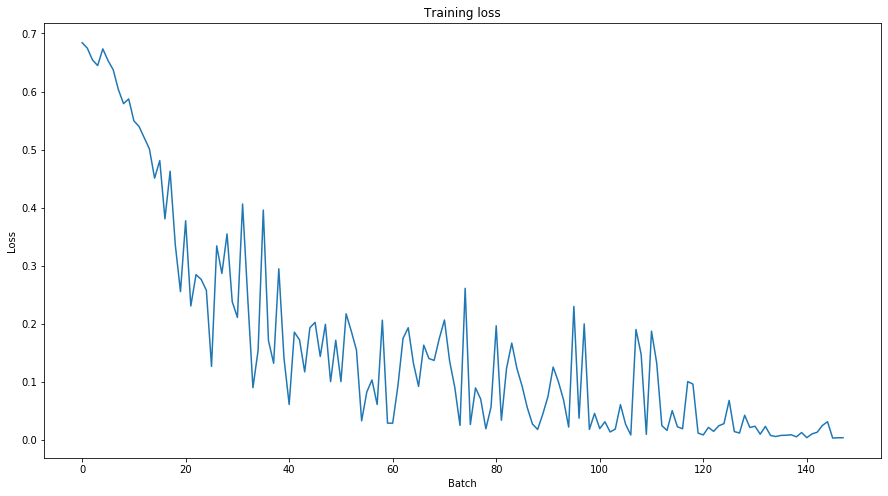

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from transformers.optimization import AdamW

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(params=optimizer_grouped_parameters, lr=2e-5, weight_decay=0.01)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

model.cuda()

# BERT training loop
for _ in range(epochs):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss, _ = model(input_ids = b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = np.array(logits[0].cpu())
    print()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [79]:
ce_me_df.head()

,0,1,2
0,A strong dollar and a low oil price,profits of multinationals have dropped by 25%,causal
1,country increases imports,country decreasing balance of trade,causal
2,plunge in the value of local currency,country decreasing foreign reserves,causal
3,increase in national debt,decrease in real annual economic growth,causal
4,increase in the demand for a currency,rise in the exchange rate,causal


In [80]:
# seq_a_list = sem_eval_df[0].tolist()
# seq_b_list = sem_eval_df[1].tolist()
# labels = [1 if label=='causal' else 0 for label in sem_eval_df[2].tolist()]

# input_ids = []
# token_type_ids = []
# attention_masks = []

# for seq_a, seq_b in zip(seq_a_list, seq_b_list):
#   encoded_data = bert_tokenizer.encode_plus(text=seq_a, text_pair=seq_b, max_length=10, pad_to_max_length=True)
#   input_ids.append(encoded_data['input_ids'])
#   token_type_ids.append(encoded_data['token_type_ids'])
#   attention_masks.append(encoded_data['attention_mask'])

# Convert all of our data into torch tensors, the required datatype for our model
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits[0].cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]


print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))



Classification accuracy using BERT Fine Tuning: 88.09%
